In [1]:
import warnings
warnings.filterwarnings("ignore")

# Evaluation of fMRIPrep: comparing group t-map distributions with FSL feat

This notebook shows the distribution of t-values for fMRIPrep and feat

### 0. Setting up

Import relevant modules and set up several paths. Please point the environment variable ``FMRIPREP_DATA_HOME`` to the path where DS000030 dataset is store, and make sure that there exists a ``derivatives/`` folder under it.

In [2]:
%matplotlib inline
import os
import json
from pathlib import Path

import numpy as np
import nibabel as nb
import pandas as pd

import matplotlib as mpl
mpl.use('pgf')

import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sn
import palettable

from nilearn.image import concat_imgs, mean_img
from nilearn import plotting

In [3]:
DATA_HOME = Path(os.getenv('FMRIPREP_DATA_HOME', os.getcwd())).resolve()
DS030_HOME = DATA_HOME / 'ds000030' / '1.0.3'
DERIVS_HOME = DS030_HOME / 'derivatives'
ATLAS_HOME = DATA_HOME / 'templates' / 'mni_icbm152_nlin_asym_09c'
ANALYSIS_SMOOTHED_HOME = DERIVS_HOME / 'fmriprep_vs_feat_2.0-jd'
ANALYSIS_NOSMOOTH_HOME = DERIVS_HOME / 'fmriprep_vs_feat_nosmooth'

fprep_home = DERIVS_HOME / 'fmriprep_1.0.8' / 'fmriprep'
feat_home = DERIVS_HOME / 'fslfeat_5.0.10' / 'featbids'

FIGURES_PATH = Path(os.getenv('FMRIPREP_FIGURES', os.getcwd()))
OUTPUTS_PATH = Path(os.getenv('FMRIPREP_OUTPUTS') or '').resolve()

# Load MNI152 nonlinear, asymmetric 2009c atlas
atlas = nb.load(str(ATLAS_HOME / '1mm_T1.nii.gz'))
mask1mm = nb.load(str(ATLAS_HOME / '1mm_brainmask.nii.gz')).get_data() > 0
mask2mm = nb.load(str(ATLAS_HOME / '2mm_brainmask.nii.gz')).get_data() > 0
data = atlas.get_data()
data[~mask1mm] = data[~mask1mm].max()
atlas = nb.Nifti1Image(data, atlas.affine, atlas.header)

In [4]:
if 'inline' not in mpl.get_backend():
    sn.set_style("whitegrid", {
        'ytick.major.size': 0,
        'xtick.major.size': 5,
    })
    sn.set_context("notebook", font_scale=1)

    pgf_with_custom_preamble = {
        'ytick.major.size': 0,
        'xtick.major.size': 5,
        'ytick.major.pad': 0,
        'font.sans-serif': ['HelveticaLTStd-Light'],
        'font.family': 'sans-serif', # use serif/main font for text elements
        'text.usetex': False,    # use inline math for ticks
    }
    mpl.rcParams.update(pgf_with_custom_preamble)


    pgf_with_custom_preamble = {
    #     'font.sans-serif': ['Helvetica Light'],
    #     'font.family': 'sans-serif', # use serif/main font for text elements
        'text.usetex': True,    # use inline math for ticks
        'pgf.rcfonts': False,   # don't setup fonts from rc parameters
        'pgf.texsystem': 'xelatex',
        'verbose.level': 'debug-annoying',
        "pgf.preamble": [
    #         r'\renewcommand{\sfdefault}{phv}',
    #         r'\usepackage[scaled=.92]{helvet}',
            r"""\usepackage{fontspec}
    \setsansfont{HelveticaLTStd-Light}[
    Extension=.otf,
    BoldFont=HelveticaLTStd-Bold,
    ItalicFont=HelveticaLTStd-LightObl,
    BoldItalicFont=HelveticaLTStd-BoldObl,
    ]
    \setmainfont{HelveticaLTStd-Light}[
    Extension=.otf,
    BoldFont=HelveticaLTStd-Bold,
    ItalicFont=HelveticaLTStd-LightObl,
    BoldItalicFont=HelveticaLTStd-BoldObl,
    ]
    \setmonofont{Inconsolata-dz}
    """,
            r'\renewcommand\familydefault{\sfdefault}',
    #         r'\setsansfont[Extension=.otf]{Helvetica-LightOblique}',
    #         r'\setmainfont[Extension=.ttf]{DejaVuSansCondensed}',
    #         r'\setmainfont[Extension=.otf]{FiraSans-Light}',
    #         r'\setsansfont[Extension=.otf]{FiraSans-Light}',
        ]
    }
    mpl.rcParams.update(pgf_with_custom_preamble)

In [5]:
def extract_file(in_file, mask):
    """
    Reads a t-stats map and returns the vector of t-values that are within
    a mask, and the median value.
    """
    try:
        t_vals = nb.load(str(in_file)).get_data()[mask]
    except FileNotFoundError:
        print('Warning: "%s" not found' % in_file)
        return None, None
    return t_vals.tolist(), np.median(t_vals[t_vals > 0])

In [6]:
# Calculate medians across repetitions
all_t_fprep = {'smoothed': [], 'nosmooth': []}
all_t_feat = {'smoothed': [], 'nosmooth': []}

means_t_fprep = {'smoothed': [], 'nosmooth': []}
means_t_feat = {'smoothed': [], 'nosmooth': []}

for rep in list(range(1, 201)):
    for sample in list(range(2)):
        fprep_path = 'fmriprep_stopsignal_N050_R%03d_S%d' % (rep, sample)
        feat_path = 'fslfeat_stopsignal_N050_R%03d_S%d' % (rep, sample)
        
        group_dir = ANALYSIS_SMOOTHED_HOME / 'l2-jd'
        fprep_tvals, fprep_loc = extract_file(group_dir / fprep_path / 'tstat1.nii.gz', mask2mm)
        if fprep_tvals:
            means_t_fprep['smoothed'].append(fprep_loc)
            all_t_fprep['smoothed'] += fprep_tvals
            
        feat_tvals, feat_loc = extract_file(group_dir / feat_path / 'tstat1.nii.gz', mask2mm)
        if feat_tvals is not None:
            means_t_feat['smoothed'].append(feat_loc)
            all_t_feat['smoothed'] += feat_tvals
                
        group_dir = ANALYSIS_NOSMOOTH_HOME / 'l2-jd'
        fprep_tvals, fprep_loc = extract_file(group_dir / fprep_path / 'tstat1.nii.gz', mask2mm)
        if fprep_tvals is not None:
            means_t_fprep['nosmooth'].append(fprep_loc)
            all_t_fprep['nosmooth'] += fprep_tvals
            
        
        feat_tvals, feat_loc = extract_file(group_dir / feat_path / 'tstat1.nii.gz', mask2mm)
        if feat_tvals:
            means_t_feat['nosmooth'].append(feat_loc)
            all_t_feat['nosmooth'] += feat_tvals


all_t_feat['nosmooth'] = np.array(all_t_feat['nosmooth'])
all_t_feat['smoothed'] = np.array(all_t_feat['smoothed'])

all_t_fprep['nosmooth'] = np.array(all_t_fprep['nosmooth'])
all_t_fprep['smoothed'] = np.array(all_t_fprep['smoothed'])

## 1. Comparing t-map distributions

In the previous cell, all the $t$-values within the template mask are collected, for both samples across all repetitions of the two-groups experiment (with N=50).
Let us remind here that this experiment run 200 permutations where the 257 subjects from DS000030 are randomly sampled into two groups (here, we selected the groups with N=50).
Then, both FSL ``feat`` and _fMRIPrep_ are run on each groups and the overlap between groups is measured.

/home/oesteban/.anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/oesteban/.anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/oesteban/.anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/oesteban/.anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<Figure size 432x288 with 0 Axes>

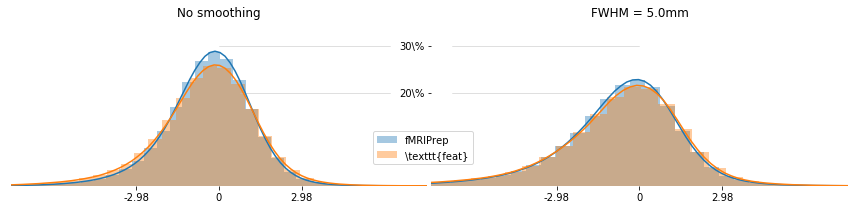

In [7]:
plt.clf()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3))
plt.subplots_adjust(wspace=0.01)

avg_nosmooth = 0.5 * (all_t_feat['nosmooth'] + all_t_fprep['nosmooth'])
diff_nosmooth = all_t_feat['nosmooth'] - all_t_fprep['nosmooth']
masked_ns = np.abs(avg_nosmooth) > 1e-3

ax1.axhline(0.3, 0.5, 0.91, color='silver', lw=0.5)
ax1.axhline(0.2, 0.55, 0.91, color='silver', lw=0.5)
sn.distplot(all_t_fprep['nosmooth'][all_t_fprep['nosmooth'] != 0],
# sn.distplot(np.random.choice(all_t_fprep['nosmooth'][all_t_fprep['nosmooth'] != 0], replace=False, size=1000),
            label='fMRIPrep', ax=ax1, norm_hist=True, kde=True)
sn.distplot(all_t_feat['nosmooth'][all_t_feat['nosmooth'] != 0],
# sn.distplot(np.random.choice(all_t_feat['nosmooth'][all_t_feat['nosmooth'] != 0], replace=False, size=1000),
            label=r'\texttt{feat}', ax=ax1, norm_hist=True, kde=True)
ax1.set_title('No smoothing');
ax1.set_xlim((-7.5, 7.5))
ax1.set_ylim((0, 0.35))
ax1.set_xticks([-2.98, 0, 2.98])
ax1.set_yticks([])
ax1.set_yticklabels([])
ax1.set_xticklabels(['-2.98', '0', '2.98'])
ax1.grid(False)

ax2.axhline(0.3, 0.05, 0.5, color='silver', lw=0.5)
ax2.axhline(0.2, 0.05, 0.45, color='silver', lw=0.5)

sn.distplot(all_t_fprep['smoothed'][all_t_fprep['smoothed'] != 0],
# sn.distplot(np.random.choice(all_t_fprep['smoothed'][all_t_fprep['smoothed'] != 0], replace=False, size=1000),
            label='fMRIPrep', ax=ax2, norm_hist=True, kde=True)
sn.distplot(all_t_feat['smoothed'][all_t_feat['smoothed'] != 0],
# sn.distplot(np.random.choice(all_t_feat['smoothed'][all_t_feat['smoothed'] != 0], replace=False, size=1000),
            label=r'\texttt{feat}', ax=ax2, norm_hist=True, kde=True)
ax2.set_title('FWHM = 5.0mm');
ax2.set_xlim((-7.5, 7.5))
ax2.set_ylim((0, 0.35))
ax2.set_yticklabels(['20\%', '30\%'])
ax2.set_yticks([0.20, 0.30])
ax2.set_xticks([-2.98, 0, 2.98])
ax2.set_xticklabels(['-2.98', '0', '2.98'])
ax2.grid(False)


ax2.legend(loc='lower center', bbox_to_anchor=(-0.02, 0.1))
sn.despine(left=True, bottom=True)

# Store the figure iff we are not plotting inline.
if 'inline' not in mpl.get_backend():
    plt.savefig(str(FIGURES_PATH / 'figureS07b.pdf'),
                format='pdf', bbox_inches='tight', pad_inches=0.2, dpi=300)
    plt.savefig(str(FIGURES_PATH / 'figureS07b.png'),
                format='png', bbox_inches='tight', pad_inches=0.2, dpi=300)

## 2. Comparing distributions as a test-retest experiment
In this second part, we use [Bland-Altman plots](https://en.wikipedia.org/wiki/Bland%E2%80%93Altman_plot) using the t-values obtained with FSL feat as first measurement and those obtained with _fMRIPrep_ as second measurement, showing that the differences between both are minimal, and likely derived from the different effective smoothing of the data.

### 2.1. Unsmoothed data

/home/oesteban/.anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'height'
  s)


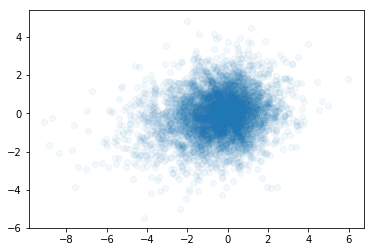

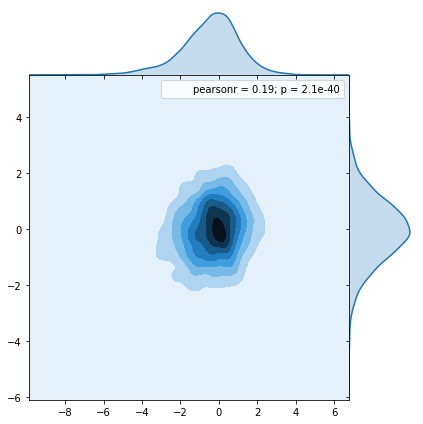

In [8]:
avgs = 0.5 * (all_t_feat['nosmooth'] + all_t_fprep['nosmooth'])
nonzero = np.abs(avgs) > 1e-3

# Randomly sample before plotting, not to clutter the figure
idxs = np.random.choice(list(range(len(avgs[nonzero]))), replace=False, size=5000)
diff = all_t_feat['nosmooth'][nonzero] - all_t_fprep['nosmooth'][nonzero]
plt.scatter(avgs[nonzero][idxs], diff[idxs], alpha=0.05)

g = sn.jointplot(avgs[nonzero][idxs], diff[idxs], kind="kde", height=7, space=0)

Let's look into both tails of the plot by filtering out those voxels that had an average (feat, _fMRIPrep_) < 2.0

/home/oesteban/.anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'height'
  s)


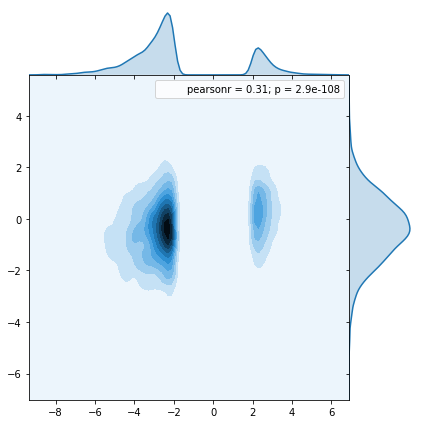

In [9]:
nonzero = np.abs(avgs) > 2.0
idxs = np.random.choice(list(range(len(avgs[nonzero]))), replace=False, size=5000)
diff = all_t_feat['nosmooth'][nonzero] - all_t_fprep['nosmooth'][nonzero]
g = sn.jointplot(avgs[nonzero][idxs], diff[idxs], kind="kde", height=7, space=0)

### 2.2. Smoothed data

/home/oesteban/.anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'height'
  s)


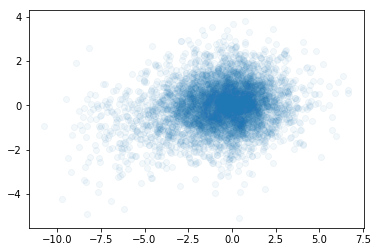

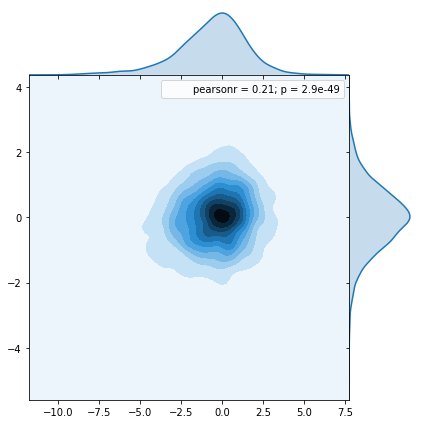

In [10]:
avgs = 0.5 * (all_t_feat['smoothed'] + all_t_fprep['smoothed'])
nonzero = np.abs(avgs) > 1e-3
idxs = np.random.choice(list(range(len(avgs[nonzero]))), replace=False, size=5000)
diff = all_t_feat['smoothed'][nonzero] - all_t_fprep['smoothed'][nonzero]
plt.scatter(avgs[nonzero][idxs], diff[idxs], alpha=0.05)

g = sn.jointplot(avgs[nonzero][idxs], diff[idxs], kind="kde", height=7, space=0)

/home/oesteban/.anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'height'
  s)


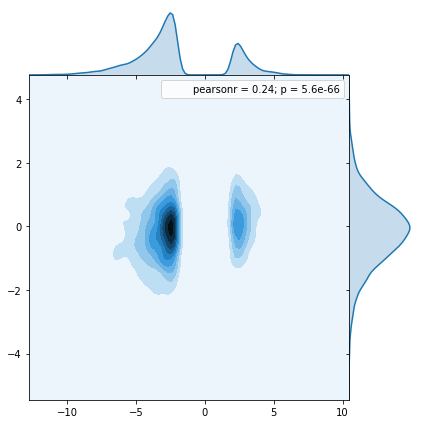

In [11]:
nonzero = np.abs(avgs) > 2.0
idxs = np.random.choice(list(range(len(avgs[nonzero]))), replace=False, size=5000)
diff = all_t_feat['smoothed'][nonzero] - all_t_fprep['smoothed'][nonzero]
g = sn.jointplot(avgs[nonzero][idxs], diff[idxs], kind="kde", height=7, space=0)

## 3. Plotting the distribution of medians of t-values

/home/oesteban/.anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/oesteban/.anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/oesteban/.anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/oesteban/.anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


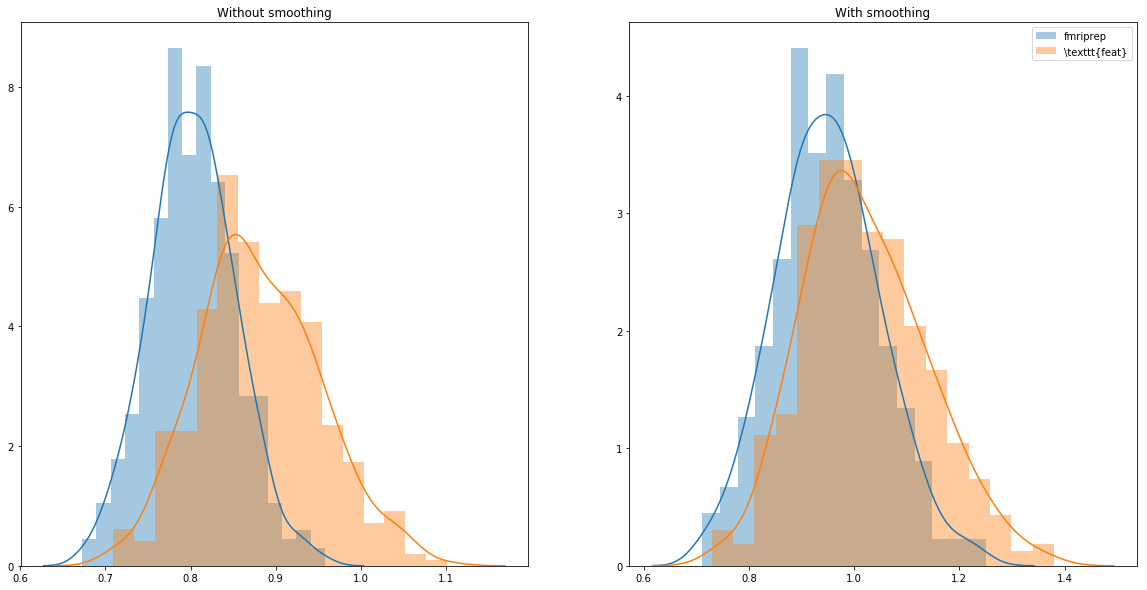

In [12]:
fig = plt.figure(figsize=(20, 10))

ax1 = plt.subplot(1, 2, 1)
sn.distplot(means_t_fprep['nosmooth'], label='fmriprep', ax=ax1)
sn.distplot(means_t_feat['nosmooth'], label=r'\texttt{feat}', ax=ax1)
ax1.set_title('Without smoothing');


ax2 = plt.subplot(1, 2, 2)
sn.distplot(means_t_fprep['smoothed'], label='fmriprep', ax=ax2)
sn.distplot(means_t_feat['smoothed'], label=r'\texttt{feat}', ax=ax2)
ax2.set_title('With smoothing');
plt.legend()